# Parallel coordinates plots

after https://benalexkeen.com/parallel-coordinates-in-matplotlib/

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [2]:
sns.set()

In [3]:
%matplotlib inline

## Load Data

In [4]:
df = pd.read_csv("data/datasets_309_669_Auto.csv")

In [5]:
df['horsepower'] = pd.to_numeric(df['horsepower'].replace('?', np.nan))
df['mpg'] = pd.cut(df['mpg'], [8, 16, 24, 32, 50])

In [6]:
mpg_ranks = {mpg: rank for rank, mpg in enumerate(sorted(df["mpg"].unique()))}

In [7]:
mpg_ranks

{Interval(8, 16, closed='right'): 0,
 Interval(16, 24, closed='right'): 1,
 Interval(24, 32, closed='right'): 2,
 Interval(32, 50, closed='right'): 3}

In [8]:
df["mpg_rank"] = df["mpg"].apply(mpg_ranks.get)

In [9]:
df.dtypes

mpg             category
cylinders          int64
displacement     float64
horsepower       float64
weight             int64
acceleration     float64
year               int64
origin             int64
name              object
mpg_rank        category
dtype: object

## Pandas' implementation of parallel_coordinates

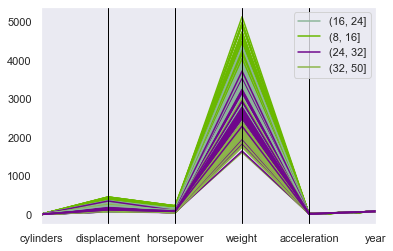

In [10]:
plt.figure()

pd.plotting.parallel_coordinates(
    df[['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'year']], 
    class_column='mpg')

plt.show()

Pandas parallel coordinates implementations places all factors on the same axis, which makes many types of data unusable for visual analysis. To make a better chart, we need to normalize the data

## Custom implementation

In [11]:
import matplotlib.pyplot as plt
from matplotlib import gridspec, cm, colors, ticker, dates as mdates


def strip_prefix(x, s):
    return x[len(s):] if x.startswith(s) else x


def parallel_coordinates(df, dimensions=None, color=None, prefix=None, sort_ascending=None,
                         cmap="cividis", figsize=(15, 8), tick_length=6, log_scale=None):
    """
    Based on https://stackoverflow.com/q/8230638/597371
    
    Example usage with Optuna `study' object:
    
    parallel_coordinates(study.trials_dataframe(), 
        dimensions=['num_leaves', 'n_estimators', 'max_depth', "learning_rate"], 
        color="value", prefix="params_")
        
    """
    
    if dimensions is None:
        columns = df.columns
        dimensions = columns if prefix is None \
            else [strip_prefix(c, prefix) for c in columns]
    else:
        columns = dimensions if prefix is None \
            else ["{}{}".format(prefix, d) for d in dimensions]

    if color is not None:
        if sort_ascending is not None:
            df = df.sort_values(by=color, ascending=sort_ascending)
        color = df[color]
    
    data = df[columns]
    
    dims = len(dimensions)
    xs = range(dims)
    
    fig = plt.figure(figsize=figsize)
    grid = gridspec.GridSpec(1, dims - 1, figure=fig)
    grid.update(wspace=0.0, hspace=0.0)
    axes = [plt.subplot(gs) for gs in grid]

    # Log scaling
    if log_scale is not None:
        if prefix is not None:
            log_scale = ["{}{}".format(prefix, col) for col in log_scale]
        data = pd.DataFrame({
            col: (np.log10(data[col]) if col in log_scale else data[col]) for col in columns 
        })
    
    # Calculate the limits on the data
    min_max_range = list()
    for col in columns:
        ds = data[col]
        mn, mx = ds.min(), ds.max()
        if mn == mx:
            mn -= 0.5
            mx = mn + 1.
        r = float(mx - mn)
        min_max_range.append((mn, r))

    # Normalize data
    data = pd.DataFrame({
        col: (data[col] - mn) / r for col, (mn, r)
        in zip(columns, min_max_range)
    })

    # Normalize item number values to colormap
    if isinstance(cmap, str):
        cmap = getattr(cm, cmap)
    norm = None if color is None \
        else colors.Normalize(vmin=color.min(), vmax=color.max())
    
    # Plot data on all the subplots
    for i, ax in enumerate(axes):
        for dsi, d in data.iterrows():
            rgba_color = "C0" if color is None \
                else cmap(norm(color.loc[dsi]), bytes=False)
            ax.plot(xs, d.values, color=rgba_color)
        ax.set_xlim([xs[i], xs[i + 1]])

    # Set the x axis ticks 
    for dimension, (ax, x) in enumerate(zip(axes, xs)):
        ax.set_ylim(-0.05, 1.05)
        ax.xaxis.set_major_locator(ticker.FixedLocator([x]))
        mn, r = min_max_range[dimension]
        ylabels = mn + r * ax.get_yticks()
        ax.set_xticklabels([dimensions[dimension]])
        ax.set_yticklabels(['%4.2f' % y for y in ylabels])
        ax.tick_params(top=False, bottom=False, left=True, right=False, 
                       labelleft=True, labelright=False, length=tick_length)
        ax.grid(False)
        
    # Move the final axis' ticks to the right-hand side
    ax = axes[-1].twinx()
    ax.set_ylim(-0.05, 1.05)
    dimension += 1
    ax.xaxis.set_major_locator(ticker.FixedLocator([xs[-2], xs[-1]]))
    mn, r = min_max_range[dimension]
    ylabels = mn + r * ax.get_yticks()
    ax.set_xticklabels([dimensions[dimension - 1], dimensions[dimension]])
    ax.set_yticklabels(['%4.2f' % y for y in ylabels])
    ax.tick_params(top=False, bottom=False, left=False, right=True, 
                   labelleft=False, labelright=True, length=tick_length)
    ax.grid(False)

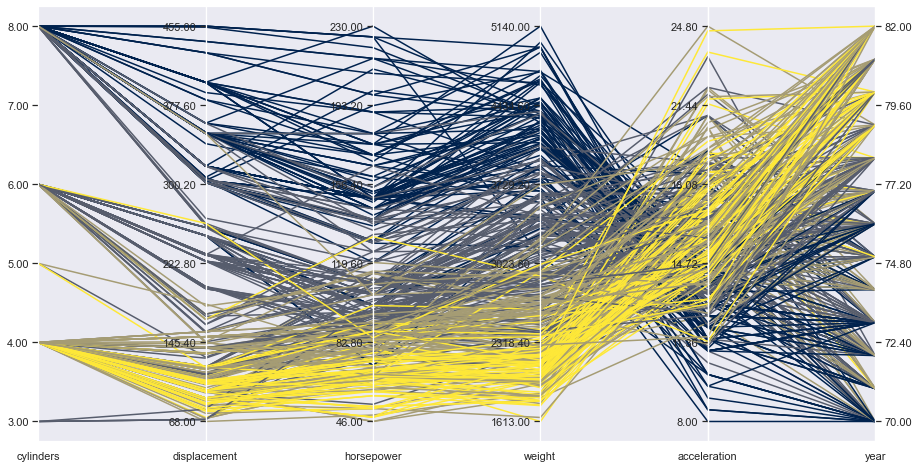

In [12]:
parallel_coordinates(df, color="mpg_rank",
                     dimensions=['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'year'])

The chart makes it immediately clear that high mileage cars have low weight, horse power, displacement, and typically four cyllinders. They also tend to have higher acceleration (probably a function of lower weight) and they started being released in late 1970s.

We can also discern that weight appears to be the strongest factor influencing gas consumption. Some of it, of course, is due to there being two types of cars: heavy and light. However we can still consider weight as a "causal" factor: although horsepower and related factors are also important, the primary reason certain vehicles are being made with high horsepower engines is because they are designed to be heavy.

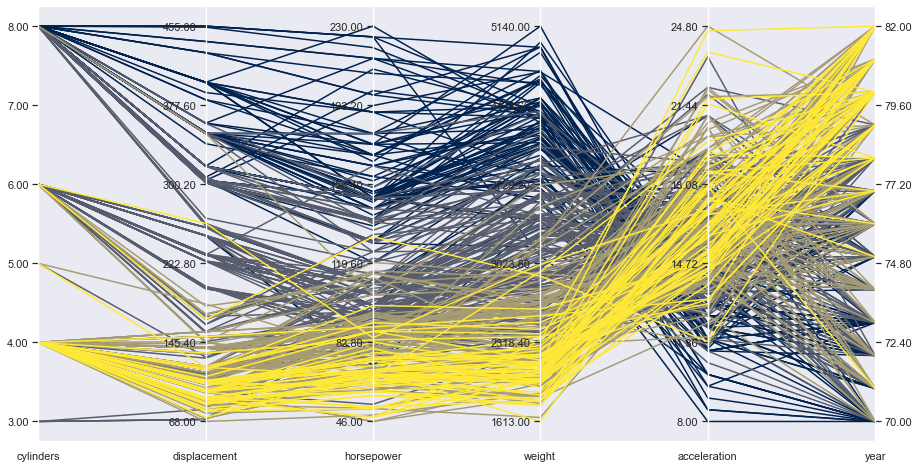

In [14]:
parallel_coordinates(df, color="mpg_rank", sort_ascending=True,
                     dimensions=['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'year'])

Even more clarity is achieved by sorting the dataframe by `mpg_rank` column so that glyphs corresponding to high mileage cares are plotted on top.

## Other implementations

Plotly has a [nice implementation](https://plotly.com/python/parallel-coordinates-plot/) of parallel coordindate plots, however it has downsides in that it 1) requires Plotly, and 2) is potentially less flexible, i.e. no easy way to use log-scale Y axes.